# Riskfolio-Lib Tutorial: 
<br><a href="https://www.kqzyfj.com/click-101360347-15150084?url=https%3A%2F%2Flink.springer.com%2Fbook%2F9783031843037" target="_blank">
<div>
<img src="https://raw.githubusercontent.com/dcajasn/Riskfolio-Lib/refs/heads/master/docs/source/_static/Button.png" height="40" />
</div>
<br>
</a>
<a href="https://www.paypal.com/ncp/payment/GN55W4UQ7VAMN" target="_blank">
<div>
<img src="https://raw.githubusercontent.com/dcajasn/Riskfolio-Lib/refs/heads/master/docs/source/_static/Button2.png" height="40" />
</div>
</a>

<br><a href='https://ko-fi.com/B0B833SXD' target='_blank'><img height='36' style='border:0px;height:36px;' src='https://cdn.ko-fi.com/cdn/kofi1.png?v=2' border='0' alt='Buy Me a Coffee at ko-fi.com' /></a> 
<br>
<br>__[Financionerioncios](https://financioneroncios.wordpress.com)__
<br>__[Orenji](https://www.linkedin.com/company/orenj-i)__
<br>__[Riskfolio-Lib](https://riskfolio-lib.readthedocs.io/en/latest/)__
<br>__[Dany Cajas](https://www.linkedin.com/in/dany-cajas/)__
## Tutorial 11: Risk Parity Portfolio Optimization using Risk Factors and Stepwise Regression

## 1. Downloading the data:

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import warnings

warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:.4%}'.format

# Date range
start = '2016-01-01'
end = '2019-12-30'

# Tickers of assets
assets = ['JCI', 'TGT', 'CMCSA', 'CPB', 'MO', 'APA', 'MMC', 'JPM',
          'ZION', 'PSA', 'BAX', 'BMY', 'LUV', 'PCAR', 'TXT', 'TMO',
          'DE', 'MSFT', 'HPQ', 'SEE', 'VZ', 'CNP', 'NI', 'T', 'BA']
assets.sort()

# Tickers of factors

factors = ['MTUM', 'QUAL', 'VLUE', 'SIZE', 'USMV']
factors.sort()

tickers = assets + factors
tickers.sort()

# Downloading data
data = yf.download(tickers, start = start, end = end, auto_adjust=False)
data = data.loc[:,('Adj Close', slice(None))]
data.columns = tickers

[*********************100%***********************]  30 of 30 completed


In [2]:
# Calculating returns

X = data[factors].pct_change().dropna()
Y = data[assets].pct_change().dropna()

display(X.head())

,MTUM,QUAL,SIZE,USMV,VLUE
Date,,,,,
2016-01-05,0.4735%,0.2672%,0.0000%,0.6780%,0.1634%
2016-01-06,-0.5266%,-1.1914%,-0.5380%,-0.6253%,-1.8277%
2016-01-07,-2.2293%,-2.3798%,-1.7181%,-1.6215%,-2.1609%
2016-01-08,-0.9548%,-1.1376%,-1.1978%,-1.0086%,-1.0873%
2016-01-11,0.6043%,0.1479%,-0.5898%,0.1491%,-0.6183%


## 2. Estimating Mean Variance Portfolios

### 2.1 Estimating the loadings matrix.

This part is just to visualize how Riskfolio-Lib calculates a loadings matrix.

In [3]:
import riskfolio as rp

step = 'Forward' # Could be Forward or Backward stepwise regression
loadings = rp.loadings_matrix(X=X, Y=Y, stepwise=step)

loadings.style.format("{:.4f}").background_gradient(cmap='RdYlGn')

,const,MTUM,QUAL,SIZE,USMV,VLUE
APA,-0.0006,-0.6551,0.0000,0.9406,-0.7883,1.7237
BA,0.0005,0.0000,1.1744,0.3616,-0.4322,0.0000
BAX,0.0003,0.3146,0.0000,0.0000,0.7717,0.0000
BMY,-0.0003,0.0000,0.8123,0.0000,0.0000,0.0000
CMCSA,0.0001,0.0000,0.4958,0.0000,0.4962,0.0000
CNP,0.0001,-0.5595,-0.2157,0.0000,1.8341,0.0000
CPB,-0.0003,-0.4781,-0.5994,0.0000,2.0793,0.0000
DE,0.0004,0.0000,0.0000,0.3631,0.0000,0.8090
HPQ,0.0002,0.0000,0.0000,0.0000,0.0000,1.2514
JCI,0.0001,0.0000,0.0000,0.3411,0.0000,0.5797


### 2.2 Calculating the portfolio that maximizes Sharpe ratio.

In [4]:
# Building the portfolio object
port = rp.Portfolio(returns=Y)

# Calculating optimum portfolio

# Select method and estimate input parameters:

method_mu='hist' # Method to estimate expected returns based on historical data.
method_cov='hist' # Method to estimate covariance matrix based on historical data.

port.assets_stats(method_mu=method_mu, method_cov=method_cov)

port.factors = X
port.factors_stats(method_mu=method_mu, method_cov=method_cov)

# Estimate optimal portfolio:

model='FM' # Factor Model
rm = 'MV' # Risk measure used, this time will be variance
obj = 'Sharpe' # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
hist = False # Use historical scenarios for risk measures that depend on scenarios
rf = 0 # Risk free rate
l = 0 # Risk aversion factor, only useful when obj is 'Utility'

w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

display(w.T)

,APA,BA,BAX,BMY,CMCSA,CNP,CPB,DE,HPQ,JCI,...,NI,PCAR,PSA,SEE,T,TGT,TMO,TXT,VZ,ZION
weights,0.0000%,5.9509%,11.8692%,0.0000%,0.0000%,9.7095%,0.0000%,4.3627%,0.0000%,0.0000%,...,10.4804%,0.0000%,0.0000%,0.0000%,0.0000%,5.5106%,1.2994%,0.0000%,4.0980%,0.0000%


### 2.3 Plotting portfolio composition

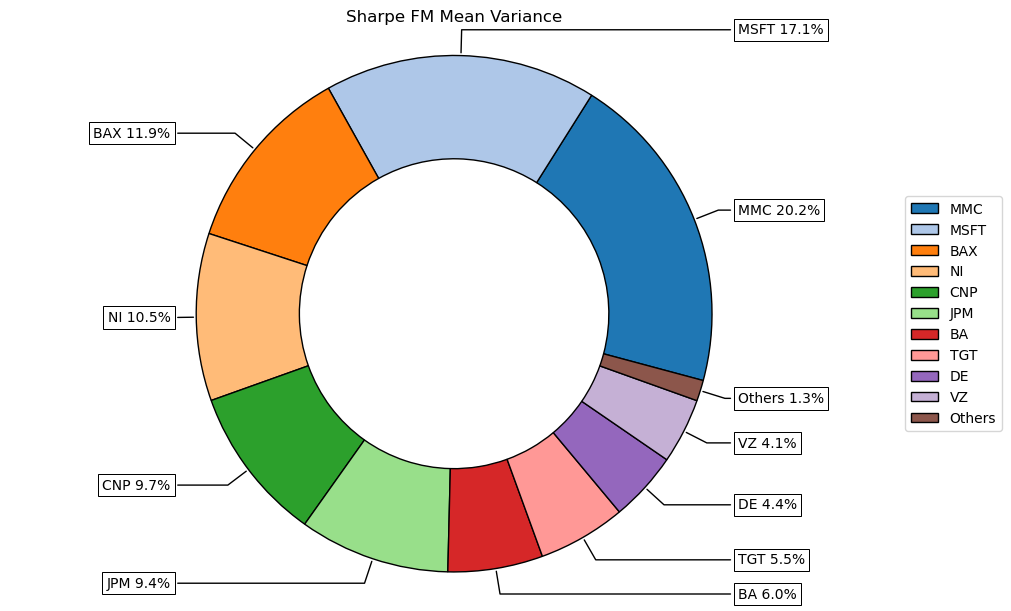

In [5]:
# Plotting the composition of the portfolio

ax = rp.plot_pie(w=w, title='Sharpe FM Mean Variance', others=0.05, nrow=25, cmap = "tab20",
                 height=6, width=10, ax=None)

### 2.3 Plotting Risk Contribution

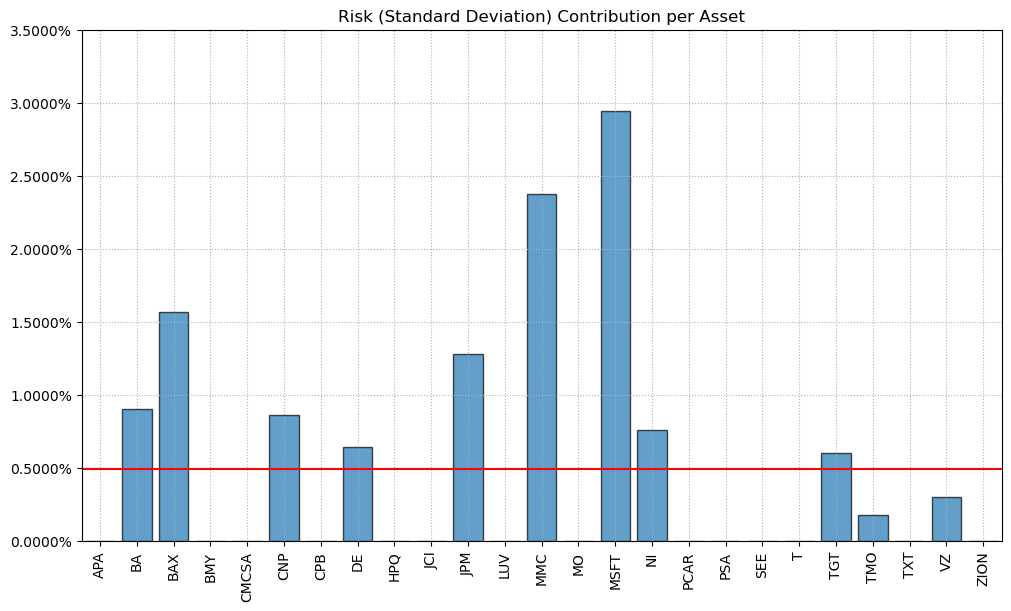

In [6]:
# Plotting the risk composition of the portfolio

ax = rp.plot_risk_con(w, cov=port.cov, returns=port.returns, rm=rm, rf=0, alpha=0.01,
                      color="tab:blue", height=6, width=10, ax=None)

## 3. Estimating Risk Parity Portfolios Using Risk Factors with Other Risk Measures

In this part I will calculate risk parity portfolios using factors models. First I'm going to calculate risk parity portfolio when we use variance as risk measure, then I'm going to calculate the risk parity portfolios for all available risk measures.

### 3.1 Calculating the risk parity portfolio for variance.

In [7]:
b = None # Risk contribution constraints vector

w_rp = port.rp_optimization(model=model, rm=rm, rf=rf, b=b, hist=hist)

display(w_rp.T)

,APA,BA,BAX,BMY,CMCSA,CNP,CPB,DE,HPQ,JCI,...,NI,PCAR,PSA,SEE,T,TGT,TMO,TXT,VZ,ZION
weights,2.3351%,3.1187%,3.9877%,4.0281%,4.0297%,5.3657%,5.2661%,3.0160%,2.7125%,3.7665%,...,6.5955%,3.0652%,6.6766%,3.6180%,4.7122%,3.8286%,3.3390%,3.0019%,5.4390%,3.0063%


### 3.2 Plotting portfolio composition

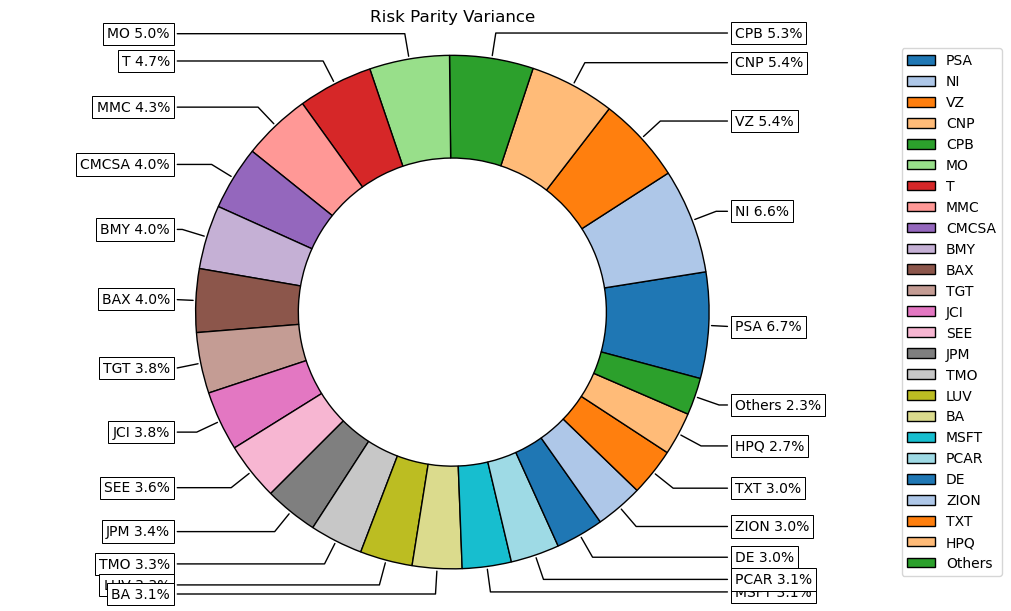

In [8]:
ax = rp.plot_pie(w=w_rp, title='Risk Parity Variance', others=0.05, nrow=25, cmap = "tab20",
                 height=6, width=10, ax=None)

### 3.3  Plotting Risk Composition

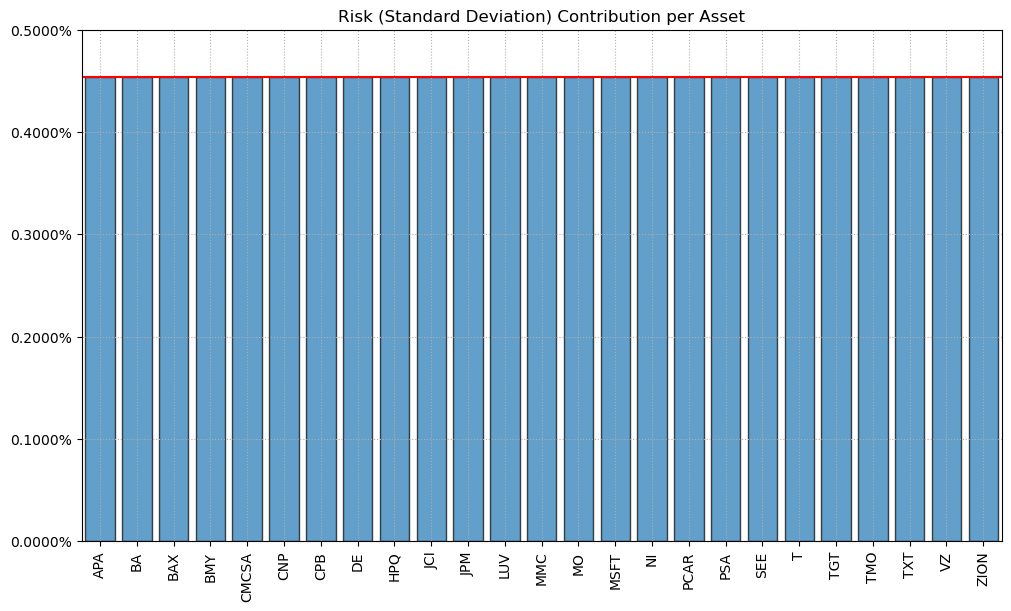

In [9]:
ax = rp.plot_risk_con(w_rp, cov=port.cov_fm, returns=port.returns_fm, rm=rm, rf=0, alpha=0.01,
                      color="tab:blue", height=6, width=10, ax=None)

### 3.4 Calculate Optimal Portfolios for Several Risk Measures.

In [10]:
# Risk Measures available:
#
# 'MV': Standard Deviation.
# 'MAD': Mean Absolute Deviation.
# 'MSV': Semi Standard Deviation.
# 'FLPM': First Lower Partial Moment (Omega Ratio).
# 'SLPM': Second Lower Partial Moment (Sortino Ratio).
# 'CVaR': Conditional Value at Risk.
# 'EVaR': Entropic Value at Risk
# 'CDaR': Conditional Drawdown at Risk of uncompounded cumulative returns.
# 'EDaR': Entropic Drawdown at Risk of uncompounded cumulative returns.
# 'UCI': Ulcer Index of uncompounded cumulative returns.

# port.reset_linear_constraints() # To reset linear constraints (factor constraints)

rms = ['MV', 'MAD', 'MSV', 'FLPM', 'SLPM',
       'EVaR', 'CVaR', 'CDaR', 'UCI', 'EDaR']

w_s = pd.DataFrame([])

# When we use hist = True the risk measures all calculated
# using historical returns, while when hist = False the
# risk measures are calculated using the expected returns 
#  based on risk factor model: R = a + B * F

hist = False

for i in rms:
    w = port.rp_optimization(model=model, rm=i, rf=rf, b=b, hist=hist)
    w_s = pd.concat([w_s, w], axis=1)
    
w_s.columns = rms

In [11]:
w_s.style.format("{:.2%}").background_gradient(cmap='YlGn')

,MV,MAD,MSV,FLPM,SLPM,EVaR,CVaR,CDaR,UCI,EDaR
APA,2.34%,2.31%,2.38%,2.09%,2.26%,2.74%,2.27%,1.60%,1.49%,1.40%
BA,3.12%,3.13%,2.98%,3.34%,3.05%,3.24%,2.88%,2.96%,3.42%,2.42%
BAX,3.99%,3.98%,3.75%,4.26%,3.85%,3.73%,3.71%,4.27%,4.99%,3.71%
BMY,4.03%,4.51%,4.30%,4.21%,4.15%,4.40%,4.03%,3.18%,3.03%,2.77%
CMCSA,4.03%,4.10%,3.94%,4.17%,3.95%,3.98%,3.83%,3.72%,3.89%,3.27%
CNP,5.37%,5.08%,5.31%,5.30%,5.46%,4.98%,5.60%,6.78%,6.61%,7.34%
CPB,5.27%,5.99%,6.34%,5.62%,6.23%,5.57%,6.65%,6.35%,5.22%,7.32%
DE,3.02%,2.91%,2.86%,3.05%,2.91%,3.13%,2.82%,2.87%,3.27%,2.43%
HPQ,2.71%,2.58%,2.55%,2.61%,2.55%,2.77%,2.50%,2.26%,2.40%,1.97%
JCI,3.77%,3.74%,3.67%,3.71%,3.65%,3.97%,3.57%,3.20%,3.32%,2.76%


<Axes: >

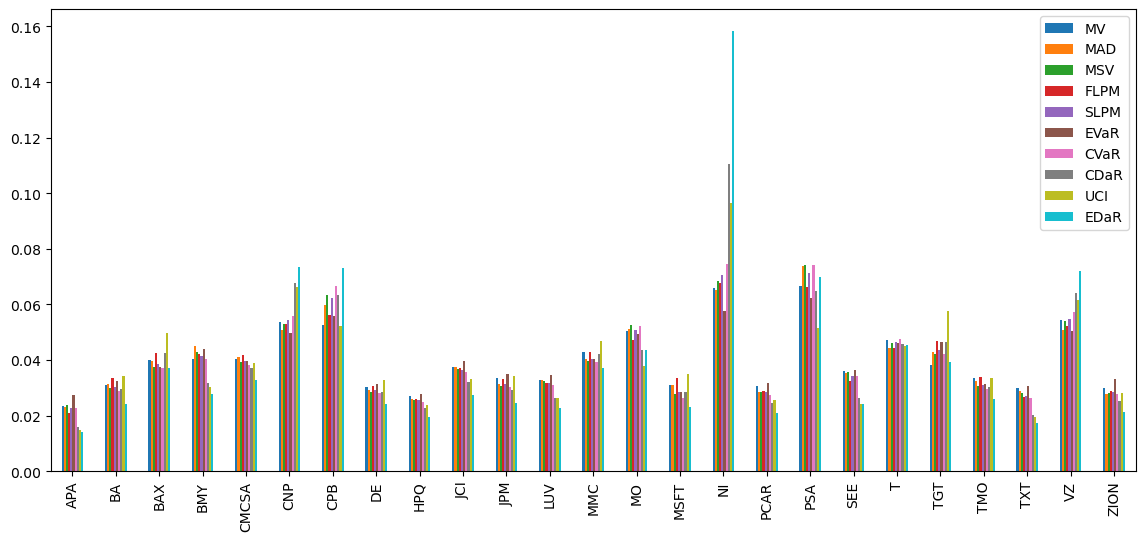

In [12]:
import matplotlib.pyplot as plt

# Plotting a comparison of assets weights for each portfolio

fig = plt.gcf()
fig.set_figwidth(14)
fig.set_figheight(6)
ax = fig.subplots(nrows=1, ncols=1)

w_s.plot.bar(ax=ax)